## Example: Portfolio Allocation Drift without Active Management
This example will familiarize students with the notion of portfolio drift, i.e., the change in the optimal allocation that occurs after a portfolio is established and nothing is done to reallocate the assets in the portfolio.

### Why does drift occur?
The weight of asset $i$ in a portfolio $\mathcal{P}$ is allocated based upon the _value fraction_ of the total portfolio value. Initially, that value is the budget you have allocated to risky assets; however, the portfolio’s value changes over time because of price fluctuations. The _value fraction_ of asset $i$ in portfolio $\mathcal{P}$ is given by:

$$
\omega_{i} = \frac{n_{i}S_{i}}{\sum_{j\in\mathcal{P}}n_{j}S_{j}}\qquad\forall{i}\in\mathcal{P}
$$

where $n_{i}$ denotes the number of shares of asset $i$, and $S_{i}$ denotes the share price of asset $i$. The numerator is the value of asset $i$ in the portfolio, while the denominator is the portfolio’s total value. Thus, because share prices change, the optimal allocation $\omega_{i}$ drifts over time if the number of shares of each asset stays the same. 

### Consequence
* If we do nothing, our portfolio is optimal in the minimum-variance sense only until the next trade, i.e., until the next market tick in which any of our assets experience a price change.

## Setup

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-Examples-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`


In [2]:
include(joinpath(_PATH_TO_SRC, "CHEME-5660-L15a-PortfolioDriftPassive-CodeLibrary.jl"));

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `11-17-2023`, along with data for a few exchange traded funds and volatility products during that time. 

In [3]:
original_dataset = load(joinpath(_PATH_TO_DATA, 
        "SP500-Daily-OHLC-1-3-2018-to-11-17-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [4]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [5]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Let's get a list of firms that we have in cleaned up `dataset`, and save it in the `all_tickers` array:

In [6]:
all_tickers = keys(dataset) |> collect |> sort;
K = length(all_tickers);

### Get the 2023 `SPY` data

In [7]:
startdate = Date(2023,01,03);
SPY_dataset = dataset["SPY"];
SPY_df = filter(:timestamp => x-> x >= startdate, SPY_dataset);

## Task 1: Load Efficient Frontier and Select a Portfolio

In [8]:
efficient_frontier = load(joinpath(_PATH_TO_DATA,
        "EfficientFrontier-PortfolioDriftExample-PD1-CHEME-5660-Fall-2023.jld2")) |> x->x["dataset"]

Row,expected_excess_return,risk,tickers,w,risk_free_rate
,Float64,Float64,Array…,Array…,Float64
1,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59536e-8, 4.84921e-7, 0.506115]",0.05
2,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59536e-8, 4.85803e-7, 0.506115]",0.05
3,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59537e-8, 4.87577e-7, 0.506115]",0.05
4,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80374e-8, 9.59542e-8, 5.32657e-7, 0.506115]",0.05
5,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80382e-8, 9.59546e-8, 5.69075e-7, 0.506115]",0.05
6,0.0388449,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80362e-8, 9.59585e-8, 1.40028e-6, 0.506114]",0.05
7,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80366e-8, 9.59546e-8, 5.08398e-7, 0.506115]",0.05
8,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80371e-8, 9.59552e-8, 5.25002e-7, 0.506115]",0.05
9,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80333e-8, 9.60306e-8, 1.00265e-6, 0.506114]",0.05


#### Select a portfolio index

In [9]:
portfolio_index = 64;

In [10]:
my_list_of_tickers = efficient_frontier[portfolio_index,:tickers];
w = efficient_frontier[portfolio_index,:w] .|> x-> round(x,digits=6) .|> abs;
expected_excess_return = efficient_frontier[portfolio_index,:expected_excess_return] |> x-> round(x,digits=3)
println("The expected excess return for portfolio index $(portfolio_index) equals $(expected_excess_return)")

The expected excess return for portfolio index 64 equals 0.286


#### What is in this portfolio?

In [11]:
tmp_df = DataFrame();
for i ∈ eachindex(w)
    wᵢ = w[i];
    row_df = (
        ticker = my_list_of_tickers[i],
        allocation = wᵢ
    );
    push!(tmp_df, row_df);
end
tmp_df

Row,ticker,allocation
,String,Float64
1,PFE,0.0
2,MRK,0.021794
3,AMD,0.978206
4,MU,0.0
5,INTC,0.0
6,SPY,0.0


## Task 2: Compute the number of shares in portfolio $\mathcal{P}$
First, let's specify how much we wish to invest in risky assets store this value in the `total_budget` variable:

In [12]:
total_budget = 1000.0;

Next, get the share price (which we approximate as the volume weighted average price) for each asset in the portfolio for the `startdate`. We'll store these values in the `Sₒ::Array{Float64,1}` variable:

In [13]:
Sₒ = Array{Float64,1}()
for ticker ∈ my_list_of_tickers
    price_df = dataset[ticker];
    startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:volume_weighted_average_price]
    push!(Sₒ,startprice)
end

Finally, now that we have the `total_budget`, and the share price array `Sₒ`, we compute the number of shares of each asset that corresponds to the optimal allocation (the point in the efficient frontier) and store these values in the `Nₒ::Array{Float64,1}` variable (in this case, we allow for fractional shares):

In [14]:
Nₒ = Array{Float64,1}()
for i ∈ eachindex(w)
    
    wᵢ = w[i]
    nᵢ = (wᵢ*total_budget)/Sₒ[i];
    push!(Nₒ,nᵢ)
end
Nₒ

6-element Vector{Float64}:
  0.0
  0.19712587329095468
 15.152100943166804
  0.0
  0.0
  0.0

#### Check: Do we recover the original allocation?

In [15]:
test_array = Array{Float64,1}();
for i ∈ eachindex(w)
    
    Bᵢ = Nₒ[i]*Sₒ[i];
    push!(test_array, Bᵢ);
end
Z = sum(test_array);
w_test = (1/Z).*test_array

# assert -
for i ∈ eachindex(w)
    @assert(isapprox(w_test[i],w[i], atol=1e-6))
end

## Task 3: Compute the wealth of portfolio $\mathcal{P}$ versus `SPY`
Let's compute the value of a portfolio $\mathcal{P}$ for a `number_of_days` forward in time, where the initial composition of the portfolio $\mathcal{P}$ lies on the efficient frontier. To start, let's specify how many days to compute in the `number_of_days` variable:

In [16]:
number_of_days = 222;

Next, let's compute the performance of portfolio $\mathcal{P}$ by computing the value of each asset in the portfolio and the total value of the portfolio, starting from the initial allocation. We'll store this data in the `portfolio_performance_array` array
* Each `row` of the `portfolio_performance_array` corresponds to a `date,` while each `column` corresponds to an asset in the portfolio, with the last column holding the total value of the portfolio $\mathcal{P}$ at a particular time.

In [17]:
portfolio_performance_array = Array{Float64,2}(undef, number_of_days, length(w)+1)
for i ∈ eachindex(my_list_of_tickers)
    
    ticker = my_list_of_tickers[i];
    price_df = dataset[ticker];
    ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
    nᵢ = Nₒ[i]
    
    for j ∈ 1:number_of_days
        portfolio_performance_array[j,i] = nᵢ*ticker_data[j,:volume_weighted_average_price];
    end
end

# total -
for i ∈ 1:number_of_days
    portfolio_performance_array[i,end] = sum(portfolio_performance_array[i,1:end-1])
end

In [18]:
portfolio_performance_array

222×7 Matrix{Float64}:
 0.0  21.794    978.206  0.0  0.0  0.0  1000.0
 0.0  22.0698   979.362  0.0  0.0  0.0  1001.43
 0.0  22.2833   956.022  0.0  0.0  0.0   978.305
 0.0  22.6459   945.696  0.0  0.0  0.0   968.342
 0.0  22.0215  1030.48   0.0  0.0  0.0  1052.5
 0.0  21.8642  1023.81   0.0  0.0  0.0  1045.67
 0.0  21.8121  1033.59   0.0  0.0  0.0  1055.4
 0.0  21.9896  1059.01   0.0  0.0  0.0  1081.0
 0.0  22.0476  1066.39   0.0  0.0  0.0  1088.44
 0.0  21.8631  1086.22   0.0  0.0  0.0  1108.09
 0.0  21.5417  1081.47   0.0  0.0  0.0  1103.02
 0.0  21.6293  1033.44   0.0  0.0  0.0  1055.07
 0.0  21.584   1044.52   0.0  0.0  0.0  1066.1
 ⋮                                 ⋮    
 0.0  20.2386  1633.74   0.0  0.0  0.0  1653.98
 0.0  20.4188  1685.49   0.0  0.0  0.0  1705.91
 0.0  20.5143  1689.8    0.0  0.0  0.0  1710.32
 0.0  20.547   1717.4    0.0  0.0  0.0  1737.95
 0.0  20.5838  1723.5    0.0  0.0  0.0  1744.09
 0.0  20.2378  1732.73   0.0  0.0  0.0  1752.97
 0.0  19.98    1786.41   0.

#### Visualize
Let's visualize the relative wealth of the portfolio $W_{t}/W_{o}$ for our selected optimal portfolio versus an alternative portfolio consisting of `SPY` over the same time frame:

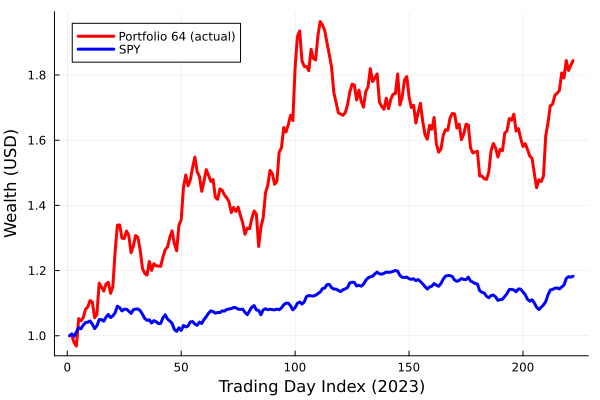

In [19]:
plot((1/portfolio_performance_array[1,end]).*portfolio_performance_array[:,end], lw=3, 
    c=:red, label="Portfolio $(portfolio_index) (actual)")
plot!((1/SPY_df[1,:volume_weighted_average_price]).*SPY_df[:,:volume_weighted_average_price], lw=3, 
    c=:blue, label="SPY")
xlabel!("Trading Day Index (2023)", fontsize=18)
ylabel!("Wealth (USD)", fontsize=18)

## Task 4: Compute the allocation drift of portfolio $\mathcal{P}$
Finally, let's compute the asset allocation $\omega_{i}$ as a function of time (and market conditions), where the number of shares of each asset was specified by the selected optimal solution (portfolio along the efficient frontier):

In [20]:
drift_array = Array{Float64,2}(undef, number_of_days, length(w))
for i ∈ 1:number_of_days
    
    total_portfolio_value = portfolio_performance_array[i,end];
    for j ∈ eachindex(my_list_of_tickers)
        drift_array[i,j] = (1/total_portfolio_value).*portfolio_performance_array[i,j]
    end
end
drift_array;

In [21]:
column_name_array = Array{String,1}();
for ticker ∈ my_list_of_tickers
    push!(column_name_array, ticker);
end
df = DataFrame(drift_array, column_name_array)

Row,PFE,MRK,AMD,MU,INTC,SPY
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.021794,0.978206,0.0,0.0,0.0
2,0.0,0.0220382,0.977962,0.0,0.0,0.0
3,0.0,0.0227775,0.977223,0.0,0.0,0.0
4,0.0,0.0233863,0.976614,0.0,0.0,0.0
5,0.0,0.0209231,0.979077,0.0,0.0,0.0
6,0.0,0.0209093,0.979091,0.0,0.0,0.0
7,0.0,0.0206672,0.979333,0.0,0.0,0.0
8,0.0,0.0203419,0.979658,0.0,0.0,0.0
9,0.0,0.0202562,0.979744,0.0,0.0,0.0


## Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.